In [76]:
import pandas as pd
import random
import ast
import numpy as np
import scipy.stats as stats 
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os, glob
import pickle
import itertools
import concurrent.futures
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
import statsmodels.api as sm
from stargazer.stargazer import Stargazer, LineLocation
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import NearestNeighbors
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from copy import deepcopy
from ax import optimize
from ax.plot.contour import plot_contour
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.plot.trace import optimization_trace_single_method


from concurrent_functions import get_q2_concurrent, calculate_q2_for_combination
plt.rcParams["font.family"] = "Times New Roman"

import torch
mps_device = torch.device("mps")

# What if we looked at every observation, rather than grouping by instance characteristics?

In [2]:
# change current working directory to the base
os.chdir('../')
os.getcwd()

'/Users/xehu/Desktop/Team Process Mapping/tpm-horse-race-modeling'

In [3]:
# full multi-task data
full_multi_task_data = pd.read_csv('../tpm-data/raw_data/full_multi_task_data.csv').rename(columns={"task": "task_name"})
full_multi_task_data = full_multi_task_data.groupby('stageId').apply(lambda x: x.loc[x['score'].idxmax()]).reset_index(drop=True)
full_multi_task_data.head()

,task_name,complexity,stageId,playerCount,score
0,Writing Story,Medium,22bJZWfgB3gfKXY6A,6,100.000000
1,Writing Story,Low,22wFrSqgf8ESM8pNY,3,100.000000
2,Divergent Association,Medium,24uBQrHu4jKFgGQ24,1,83.248037
3,Moral Reasoning,High,26RnwcdY842ZGSQtT,3,50.000000
4,Room Assignment,High,28b6Y5xQDcrdFZK2h,1,88.659794


In [4]:
# task map
task_map = pd.read_csv('./features/task-mapping/task_map.csv')
task_map = task_map.rename(columns = {"task": "task_name"})

In [5]:
task_name_mapping = {
    "Sudoku": "Sudoku",
    "Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
    "Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
    "Guess the Correlation": "Guessing the correlation",
    "Writing Story": "Writing story",
    "Room Assignment": "Room assignment task",
    "Allocating Resources": "Allocating resources to programs",
    "Divergent Association": "Divergent Association Task",
    "Word Construction": "Word construction from a subset of letters",
    "Whac a Mole": "Whac-A-Mole"
}

In [6]:
# make the names match
full_multi_task_data.loc[:, "task_name"] = full_multi_task_data["task_name"].replace(task_name_mapping)

In [7]:
# merge in the task features
full_multi_task_data = pd.merge(left = full_multi_task_data, right = task_map, on = "task_name", how = "left")

# create dummies for complexity
complexity_columns = ["High", "Low", "Medium"]
full_multi_task_data = pd.get_dummies(full_multi_task_data, columns = ["complexity"]).rename(columns = {"complexity_High": "High", "complexity_Low": "Low", "complexity_Medium": "Medium"})
full_multi_task_data[complexity_columns] = full_multi_task_data[complexity_columns].astype(int)

In [8]:
# # add in some communication features
# with open("./data_cache/multi_task_stageId_noncumulative_nonstandardized.pkl", "rb") as cleaned_pickle_file:
# 	stage_based_data = pickle.load(cleaned_pickle_file)
	
# comms_features = stage_based_data.data.groupby(GROUPING_COLS)[["gini_coefficient_sum_num_messages", "sum_num_words", "average_positive_bert"]].agg("mean").reset_index()
# overlapping_columns = set(comms_features.columns).intersection(grouped_performance_with_task_cols.columns)
# comms_features = comms_features.drop(list(overlapping_columns), axis = 1)
# grouped_performance_with_task_cols = pd.concat([grouped_performance_with_task_cols,comms_features], axis = 1)

In [39]:
# these are valid predictors
task_cols_to_use = task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis = 1).columns

In [41]:
regression_covariates_task_and_complexity = list(task_cols_to_use) + ["High", "Medium"] + ["playerCount"]

# Some purely exploratory linear regressions!

In [62]:
full_data_standardized = full_multi_task_data.copy()

In [63]:
# standardize iv set
full_data_standardized[list(task_cols_to_use)] = StandardScaler().fit_transform(full_data_standardized[list(task_cols_to_use)])

In [45]:
# standardize dv's
# full_data_standardized["score"] = StandardScaler().fit_transform(full_data_standardized["score"].values.reshape(-1, 1))

In [95]:
task_cols_to_use

Index(['Q1concept_behav', 'Q3type_1_planning', 'Q4type_2_generate',
       'Q6type_5_cc', 'Q7type_7_battle', 'Q8type_8_performance',
       'Q9divisible_unitary', 'Q10maximizing', 'Q11optimizing',
       'Q13outcome_multip', 'Q14sol_scheme_mul', 'Q15dec_verifiability',
       'Q16shared_knowledge', 'Q17within_sys_sol', 'Q18ans_recog',
       'Q19time_solvability', 'Q20type_3_type_4', 'Q22confl_tradeoffs',
       'Q23ss_out_uncert', 'Q24eureka_question', 'Q2intel_manip_1',
       'Q21intellective_judg_1', 'Q5creativity_input_1'],
      dtype='object')

In [160]:
limited_reg_coefficients = ['Q1concept_behav', 'Q3type_1_planning', 'Q4type_2_generate',
       'Q6type_5_cc', 'Q7type_7_battle', 'Q8type_8_performance',
       'Q9divisible_unitary', 'Q10maximizing', 'Q11optimizing'] + ["High", "Medium"] + ["playerCount"]

In [161]:
score_lm = sm.OLS(endog= full_data_standardized["score"], exog=sm.add_constant(full_data_standardized[limited_reg_coefficients])).fit()

models = [score_lm]
stargazer = Stargazer(models)

In [162]:
stargazer

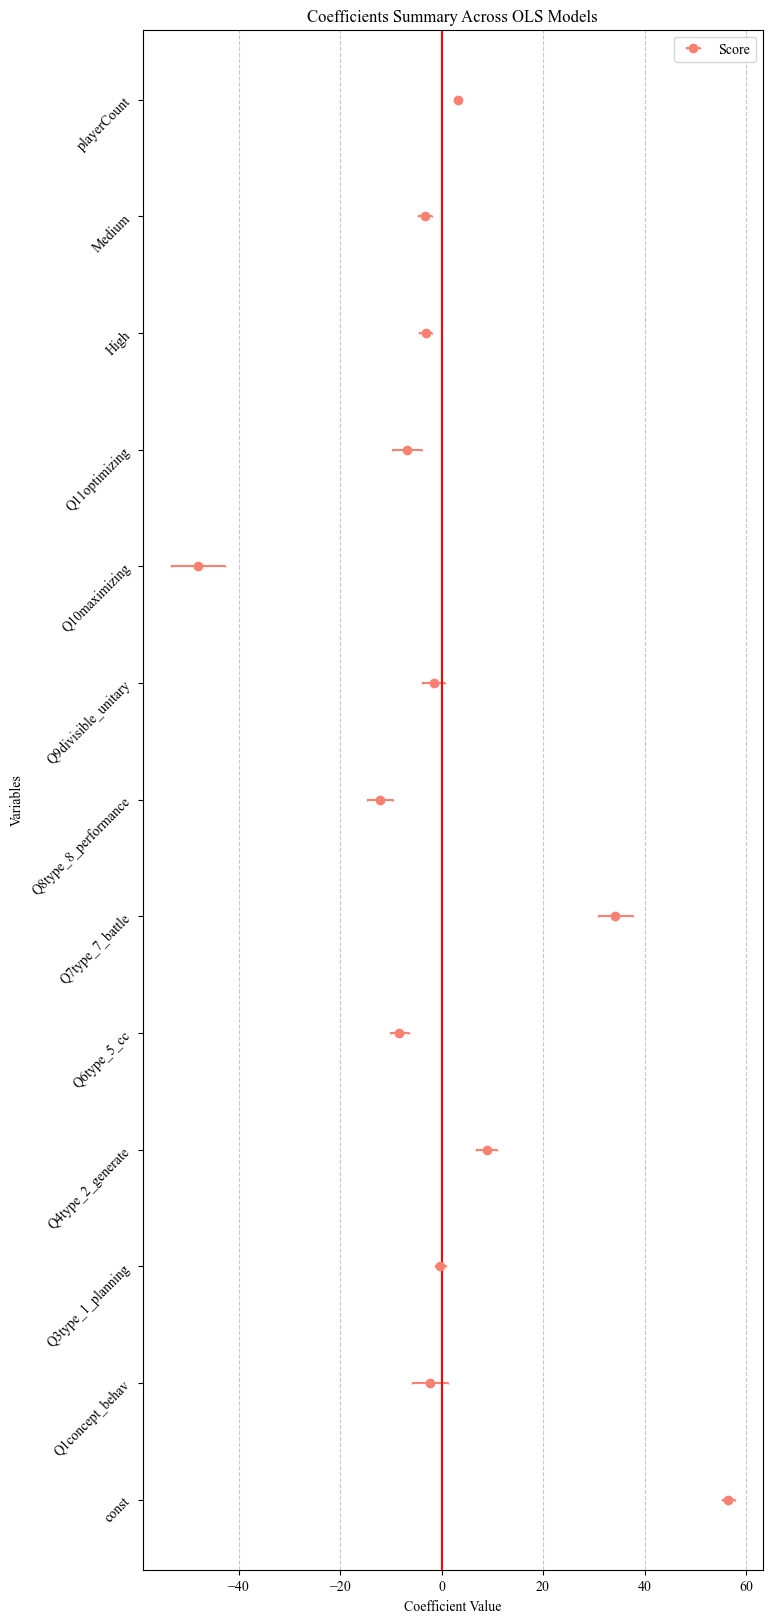

In [163]:
model_names = ["Score"]
colors = ['salmon']#, 'orange', 'gold', 'lightblue', 'violet']

# Create a DataFrame to organize the parameters for easier manipulation
params_df = pd.DataFrame([model.params for model in models], index=model_names)
stderr_df = pd.DataFrame([model.bse for model in models], index=model_names)

fig, ax = plt.subplots(figsize=(8, 20))
y_positions = np.arange(len(params_df.columns)) * 10 # spread out y-positions

for i, model_name in enumerate(model_names):
    means = params_df.loc[model_name]
    errors = stderr_df.loc[model_name]

    plt.errorbar(means, y_positions + i * 0.2, xerr=errors, fmt='o', label=f'{model_name}', color=colors[i], capsize=1)

ax.set_title('Coefficients Summary Across OLS Models')
ax.set_xlabel('Coefficient Value') 
ax.set_ylabel('Variables')  
ax.set_yticks(y_positions + (len(models) - 1) * 0.2 / 2)  
ax.set_yticklabels(params_df.columns, rotation=45, ha="right")  
ax.grid(axis='x', linestyle='--', alpha=0.7)  
ax.legend()

plt.axvline(x=0, color='r', linestyle='-') 
plt.show()

In [11]:
team_multi_task_data = full_multi_task_data[full_multi_task_data["playerCount"]>1]
individual_multi_task_data = full_multi_task_data[full_multi_task_data["playerCount"]==1]


In [13]:
team_multi_task_data

,task_name,complexity,stageId,playerCount,score
0,Writing story,Medium,22bJZWfgB3gfKXY6A,6,100.000000
1,Writing story,Low,22wFrSqgf8ESM8pNY,3,100.000000
3,Moral Reasoning (Disciplinary Action Case),High,26RnwcdY842ZGSQtT,3,50.000000
7,Word construction from a subset of letters,High,2BFbe8Tut5QLrTks9,6,69.117647
9,Word construction from a subset of letters,Medium,2E83K7ZtqnSEYc66t,3,71.428571
...,...,...,...,...,...
3192,Room assignment task,Low,zouciAtkfHj9FkpNa,3,83.000000
3195,Moral Reasoning (Disciplinary Action Case),High,zq4k4kqAGjYMJ4nP2,6,100.000000
3199,Guessing the correlation,High,zsBv2adeWuxCfMT3X,6,97.000000
3202,"Wolf, goat and cabbage transfer",High,zw2fcJ8qbMcz6LEPw,6,100.000000
